### 선형 및 비선형 회귀 기법을 사용하여 노이즈가 포함된 데이터에 대한 모델링을 수행

In [1]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

In [2]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

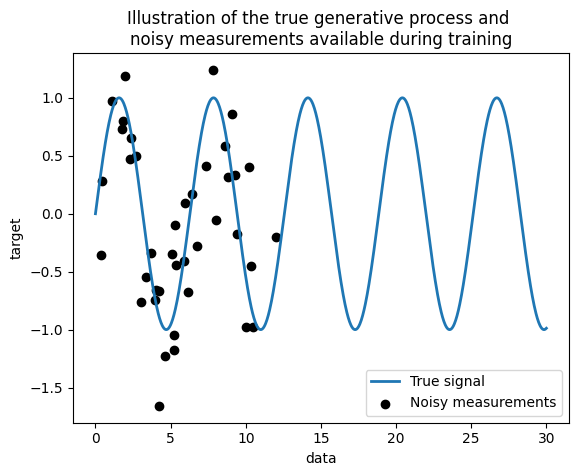

In [3]:
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

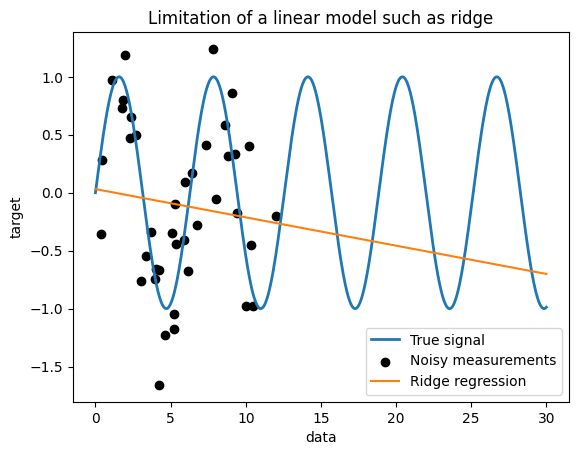

In [4]:
from sklearn.linear_model import Ridge
# 2. 릿지 회귀 (Ridge Regression)
ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

In [5]:
import time

from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge
## 3. 커널 릿지 회귀 (Kernel Ridge Regression)
kernel_ridge = KernelRidge(kernel=ExpSineSquared())

start_time = time.time()
kernel_ridge.fit(training_data, training_noisy_target)
print(
    f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds"
)




Fitting KernelRidge with default kernel: 0.008 seconds


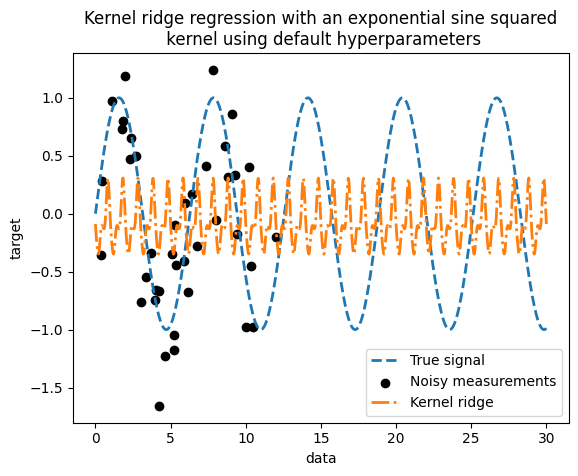

In [6]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    kernel_ridge.predict(data),
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters"
)

In [7]:
kernel_ridge.kernel


ExpSineSquared(length_scale=1, periodicity=1)

In [8]:
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}

# 4. 하이퍼파라미터 튜닝
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 2.542 seconds


In [9]:
kernel_ridge_tuned.best_params_

{'alpha': 1.991584977345022,
 'kernel__length_scale': 0.7986499491396734,
 'kernel__periodicity': 6.6072758064261095}

In [10]:
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(data)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.002 seconds


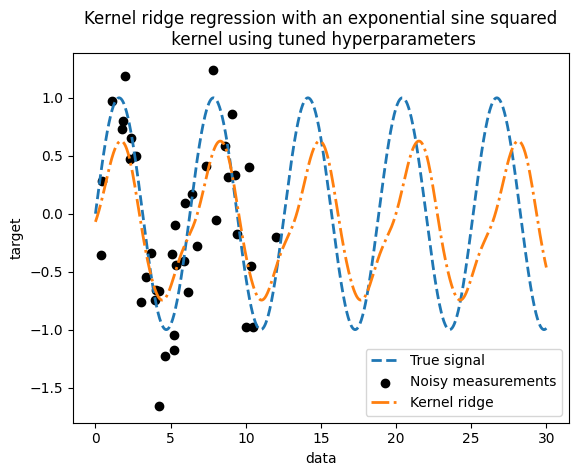

In [11]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
# 5. 가우시안 프로세스 회귀 (Gaussian Process Regression)
kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
    1e-1
)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(training_data, training_noisy_target)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor fitting: 0.086 seconds


In [13]:
gaussian_process.kernel_

0.675**2 * ExpSineSquared(length_scale=1.34, periodicity=6.57) + WhiteKernel(noise_level=0.182)

In [14]:
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)
print(
    f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor predict: 0.026 seconds


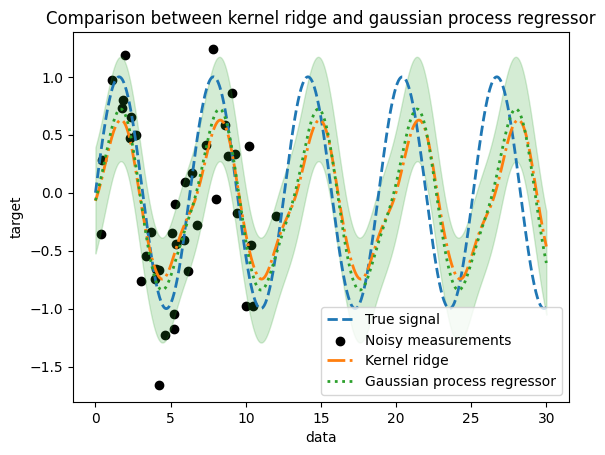

In [15]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")

In [16]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed"
) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_data, training_noisy_target)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)

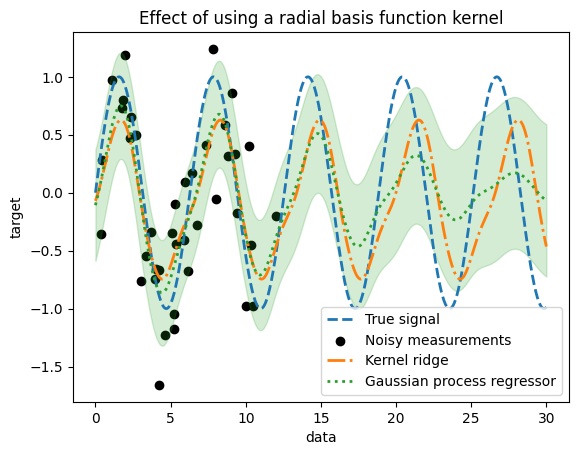

In [17]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Effect of using a radial basis function kernel")